## GAN implementation for Audio generation

In [17]:
import os
import numpy as np
import librosa
from sklearn.model_selection import train_test_split
import tensorflow as tf
from random import shuffle

In [58]:
# Verify TensorFlow can access the GPU
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


In [54]:
# Path to the directory containing the .wav files
wav_dir = '/Users/anandviswanath/Applied Ai/nsynth-train/audio'

# Get file paths from directory
def get_file_paths(directory):
    file_paths = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith(".wav"):
                file_paths.append(os.path.join(root, file))
    return file_paths

This function take (file_paths, instrument_family, max_samples, sr) as argument and loads the audio based of instrument selected, no,of sample to be loaded and maintains the expeceted_length to be sr*4

In [55]:
def load_audio_files_for_instrument(file_paths, instrument_family, max_samples=10000, sr=16000):
    shuffle(file_paths)  # Shuffle the list of file paths
    audio_data = []
    count = 0
    expected_length = sr * 4  # 4 seconds
    
    for file_path in file_paths:
        filename = os.path.basename(file_path)
        current_instrument_family = filename.split('_')[0]  # Assuming the naming convention includes the instrument type as the first part
        
        if current_instrument_family == instrument_family and count < max_samples:
            try:
                y, _ = librosa.load(file_path, sr=sr)
                if len(y) < expected_length:
                    y = np.pad(y, (0, max(0, expected_length - len(y))), 'constant')
                else:
                    y = y[:expected_length]
                audio_data.append(y)
                count += 1
            except Exception as e:
                print(f"Error loading {file_path}: {e}")
    
    return np.array(audio_data)

# Example usage
instrument_family = 'guitar'  # Specify the instrument family you want to load
file_paths = get_file_paths(wav_dir)
audio_data = load_audio_files_for_instrument(file_paths, instrument_family, max_samples=1000, sr=16000)
print(f'Loaded {len(audio_data)} audio files for instrument family: {instrument_family}')

Loaded 1000 audio files for instrument family: guitar


In [56]:
# Normalize the audio data
mean = np.mean(audio_data)
std = np.std(audio_data)
audio_data = (audio_data - mean) / std
audio_data = audio_data / np.max(np.abs(audio_data))

# Ensure each sample has the correct length (64000 for 4 seconds at 16kHz)
expected_length = int(16000 * 4)  # 4 seconds
assert audio_data.shape[1] == expected_length, f"Each audio sample should have {expected_length} points, but found {audio_data.shape[1]}"

# Reshape the audio data to fit the model input
audio_data = audio_data.reshape((audio_data.shape[0], audio_data.shape[1], 1))
print(audio_data.shape)  # Should be (num_samples, output_length, 1)

# Split the dataset into training and validation sets (80% training, 20% validation)
train_data, val_data = train_test_split(audio_data, test_size=0.2, random_state=42)
print(f'Training data shape: {train_data.shape}')
print(f'Validation data shape: {val_data.shape}')

(1000, 64000, 1)
Training data shape: (800, 64000, 1)
Validation data shape: (200, 64000, 1)


<b>Generator</b> <br>
The generator in our GAN architecture is designed to create realistic audio waveforms from random noise inputs. This synthetic audio is then passed to the discriminator.

In [47]:
from keras import layers, Sequential

def build_generator(output_length=64000, noise_dim=100):
    model = Sequential()

    model.add(layers.Input(shape=(noise_dim,)))
    model.add(layers.Dense(256 * (output_length // 256), use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((output_length // 256, 256)))  # (None, 250, 256)

    model.add(layers.Conv1DTranspose(512, 16, strides=4, padding='same', use_bias=False))  # (None, 1000, 512)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv1DTranspose(256, 16, strides=4, padding='same', use_bias=False))  # (None, 4000, 256)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv1DTranspose(128, 16, strides=4, padding='same', use_bias=False))  # (None, 16000, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv1DTranspose(64, 16, strides=2, padding='same', use_bias=False))  # (None, 32000, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv1DTranspose(1, 16, strides=2, padding='same', use_bias=False, activation='tanh'))  # (None, 64000, 1)

    return model

# Build the generator
generator = build_generator(output_length=64000, noise_dim=100)
generator.summary()

# Verify the output shape by passing a sample input
sample_input = tf.random.normal([1, 100])
sample_output = generator(sample_input)
assert sample_output.shape == (1, 64000, 1), f"Output shape mismatch: expected (1, 64000, 1), got {sample_output.shape}"
print(f"Generator output shape is correct: {sample_output.shape}")

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64000)          │     6,400,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64000)          │       256,000 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 64000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 250, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose                │ (None, 1000, 512)      │     2,097,152 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 1000, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 1000, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_1              │ (None, 4000, 256)      │     2,097,152 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 4000, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 4000, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_2              │ (None, 16000, 128)     │       524,288 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16000, 128)     │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 16000, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_3              │ (None, 32000, 64)      │       131,072 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32000, 64)      │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 32000, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_4              │ (None, 64000, 1)       │         1,024 │
│ (Conv1DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,510,528 (43.91 MB)

 Trainable params: 11,380,608 (43.41 MB)

 Non-trainable params: 129,920 (507.50 KB)

Generator output shape is correct: (1, 64000, 1)


<b>Discriminator</b><br>
The discriminator in our GAN architecture acts as a classifier that distinguishes between real and generated audio samples.<br>
The discriminator’s feedback is used to adjust the generator’s parameters, aiming to produce more realistic audio in subsequent iterations. This adversarial process continues for many epochs, with each network improving its performance over time

In [48]:
def build_discriminator(input_length=64000):
    model = Sequential()

    model.add(layers.Input(shape=(input_length, 1)))
    model.add(layers.Conv1D(64, 5, strides=2, padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv1D(128, 5, strides=2, padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv1D(256, 5, strides=2, padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv1D(512, 5, strides=2, padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model


discriminator = build_discriminator(input_length=64000)
discriminator.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 32000, 64)      │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 32000, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32000, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 16000, 128)     │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 16000, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16000, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 8000, 256)      │       164,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 8000, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8000, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 4000, 512)      │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_8 (LeakyReLU)       │ (None, 4000, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 4000, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048000)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │     2,048,001 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,909,441 (11.10 MB)

 Trainable params: 2,909,441 (11.10 MB)

 Non-trainable params: 0 (0.00 B)

In [50]:
from keras.optimizers import Adam
from keras.optimizers.schedules import ExponentialDecay
from keras import losses
import time

<b>Cross-Entropy Loss</b>: This is a common loss function used in classification tasks. It measures how well the predicted probabilities match the true labels. Here, it's being used with a setting (from_logits=True) that expects raw prediction scores (logits) rather than probabilities.

In [51]:
# Loss function
cross_entropy = losses.BinaryCrossentropy(from_logits=True)

def gradient_penalty(real_data, fake_data, discriminator):
    batch_size = tf.shape(real_data)[0]
    alpha = tf.random.uniform([batch_size, 1, 1], 0.0, 1.0)
    interpolated = real_data + alpha * (fake_data - real_data)

    with tf.GradientTape() as tape:
        tape.watch(interpolated)
        pred = discriminator(interpolated)

    gradients = tape.gradient(pred, [interpolated])[0]
    norm = tf.sqrt(tf.reduce_sum(tf.square(gradients), axis=[1, 2]))
    gradient_penalty = tf.reduce_mean((norm - 1.0) ** 2)
    return gradient_penalty

def discriminator_loss(real_output, fake_output, real_data, fake_data, discriminator, lambda_gp=10.0):
    real_labels = tf.ones_like(real_output) * 0.9 + tf.random.uniform(tf.shape(real_output), minval=0.0, maxval=0.1)
    fake_labels = tf.zeros_like(fake_output) + tf.random.uniform(tf.shape(fake_output), minval=0.0, maxval=0.1)

    real_loss = cross_entropy(real_labels, real_output)
    fake_loss = cross_entropy(fake_labels, fake_output)
    gp = gradient_penalty(real_data, fake_data, discriminator)

    total_loss = real_loss + fake_loss + lambda_gp * gp
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# Learning rate schedules
generator_lr_schedule = ExponentialDecay(
    initial_learning_rate=2e-4, decay_steps=10000, decay_rate=0.9)
discriminator_lr_schedule = ExponentialDecay(
    initial_learning_rate=2e-4, decay_steps=10000, decay_rate=0.9)

generator_optimizer = Adam(learning_rate=generator_lr_schedule, clipvalue=1.0)
discriminator_optimizer = Adam(learning_rate=discriminator_lr_schedule, clipvalue=1.0)

In [57]:
EPOCHS = 60
BATCH_SIZE = 32
noise_dim = 100
num_examples_to_generate = 16

# Seed to visualize progress
seed = tf.random.normal([num_examples_to_generate, noise_dim])

gen_losses = []
disc_losses = []
val_gen_losses = []
val_disc_losses = []

# Training function
@tf.function
def train_step(audio_batch):
    batch_size = tf.shape(audio_batch)[0]
    noise = tf.random.normal([batch_size, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_audio = generator(noise, training=True)

        real_output = discriminator(audio_batch, training=True)
        fake_output = discriminator(generated_audio, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output, audio_batch, generated_audio, discriminator)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

@tf.function
def val_step(audio_batch):
    batch_size = tf.shape(audio_batch)[0]
    noise = tf.random.normal([batch_size, noise_dim])
    generated_audio = generator(noise, training=False)

    real_output = discriminator(audio_batch, training=False)
    fake_output = discriminator(generated_audio, training=False)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output, audio_batch, generated_audio, discriminator)

    return gen_loss, disc_loss

def train(train_dataset, val_dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        # Training step
        for audio_batch in train_dataset:
            gen_loss, disc_loss = train_step(audio_batch)
        gen_losses.append(gen_loss)
        disc_losses.append(disc_loss)

        # Validation step
        for val_batch in val_dataset:
            val_gen_loss, val_disc_loss = val_step(val_batch)
        val_gen_losses.append(val_gen_loss)
        val_disc_losses.append(val_disc_loss)

        print(f'Time for epoch {epoch + 1} is {time.time()-start} sec')
        print(f'Generator loss: {gen_loss}, Discriminator loss: {disc_loss}')
        print(f'Validation Generator loss: {val_gen_loss}, Validation Discriminator loss: {val_disc_loss}')

BUFFER_SIZE = 60000

# Create the TensorFlow datasets for training and validation
train_dataset = tf.data.Dataset.from_tensor_slices(train_data).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
val_dataset = tf.data.Dataset.from_tensor_slices(val_data).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [97]:
# Train the model
train(train_dataset, val_dataset, EPOCHS)

Time for epoch 1 is 444.5312159061432 sec
Generator loss: 3.3237833976745605, Discriminator loss: 1.0228736400604248
Validation Generator loss: 0.029196299612522125, Validation Discriminator loss: 4.428248882293701
Time for epoch 2 is 425.7093880176544 sec
Generator loss: 3.1923868656158447, Discriminator loss: 0.6369719505310059
Validation Generator loss: 0.2992779612541199, Validation Discriminator loss: 2.455064296722412
Time for epoch 3 is 428.2000858783722 sec
Generator loss: 3.376708984375, Discriminator loss: 0.517177939414978
Validation Generator loss: 0.2522498071193695, Validation Discriminator loss: 2.7933709621429443


2024-07-27 21:09:04.350108: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 4 is 422.16921496391296 sec
Generator loss: 3.090792655944824, Discriminator loss: 0.7304581999778748
Validation Generator loss: 0.02513776905834675, Validation Discriminator loss: 3.8480069637298584
Time for epoch 5 is 418.4662358760834 sec
Generator loss: 4.228912353515625, Discriminator loss: 0.5339245200157166
Validation Generator loss: 0.15331792831420898, Validation Discriminator loss: 2.0799357891082764
Time for epoch 6 is 419.3967568874359 sec
Generator loss: 2.845486640930176, Discriminator loss: 0.48567983508110046
Validation Generator loss: 0.3196040391921997, Validation Discriminator loss: 1.5016518831253052
Time for epoch 7 is 420.94835209846497 sec
Generator loss: 5.867855548858643, Discriminator loss: 0.5924164056777954
Validation Generator loss: 1.4620193243026733, Validation Discriminator loss: 0.7978452444076538
Time for epoch 8 is 410.3556749820709 sec
Generator loss: 4.35325813293457, Discriminator loss: 0.5260828733444214
Validation Generator loss: 3

Since we're using the model for inference, compilation is not needed.

In [ ]:
# generator.compile(optimizer='adam', loss='crossentropy', metrics=['accuracy'])
# discriminator.compile(optimizer='adam', loss='crossentropy', metrics=['accuracy'])

In [98]:
# Save the generator model
generator.save('generator_model_guitar_50.keras')

# Save the discriminator model
discriminator.save('discriminator_model_guitar_50.keras')

In [4]:
from keras.models import load_model

# Load the generator model
generator = load_model('generator_model_guitar_50.keras')

# Load the discriminator model
discriminator = load_model('discriminator_model_guitar_50.keras')

This shows the generator loss & discriminator loss vs their counter validation part

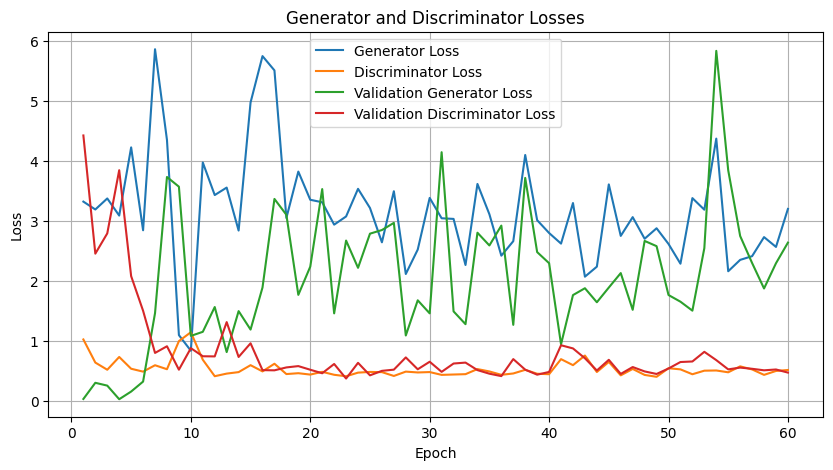

In [101]:
import matplotlib.pyplot as plt

epochs = range(1, 61)

plt.figure(figsize=(10, 5))

plt.plot(epochs, gen_losses, label='Generator Loss')
plt.plot(epochs, disc_losses, label='Discriminator Loss')
plt.plot(epochs, val_gen_losses, label='Validation Generator Loss')
plt.plot(epochs, val_disc_losses, label='Validation Discriminator Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Generator and Discriminator Losses')
plt.legend()
plt.grid(True)
plt.show()

In [5]:
import numpy as np
import tensorflow as tf
import soundfile as sf
from IPython.display import Audio

# Function to generate and save a new audio sample
def generate_audio_sample(generator, noise_dim=100, sample_rate=16000, filename='generated_audio_guitar.wav'):
    noise = tf.random.normal([1, noise_dim])
    generated_audio = generator(noise, training=False)
    generated_audio = tf.reshape(generated_audio, [-1])
    generated_audio = generated_audio.numpy()
    generated_audio = (generated_audio - np.mean(generated_audio)) / np.std(generated_audio)
    generated_audio = generated_audio / np.max(np.abs(generated_audio))
    sf.write(filename, generated_audio, sample_rate)
    return Audio(data=generated_audio, rate=sample_rate)

audio_output = generate_audio_sample(generator)
audio_output

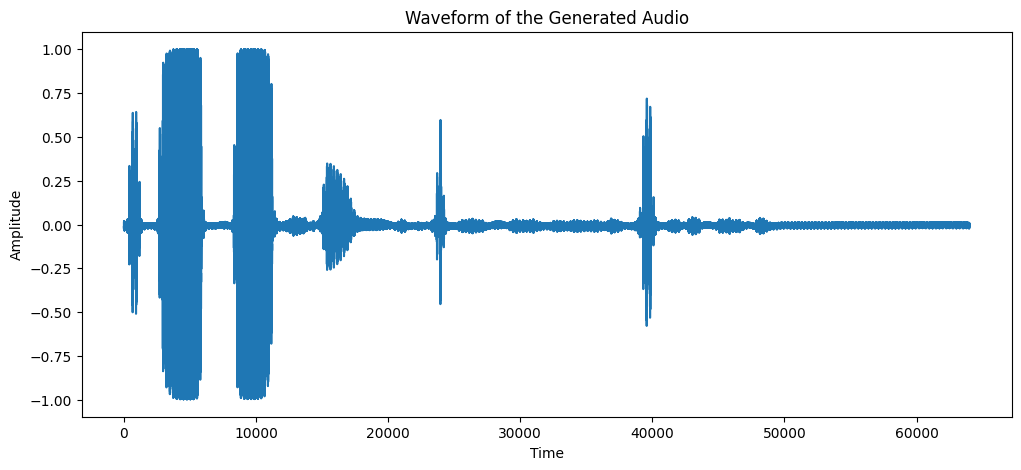

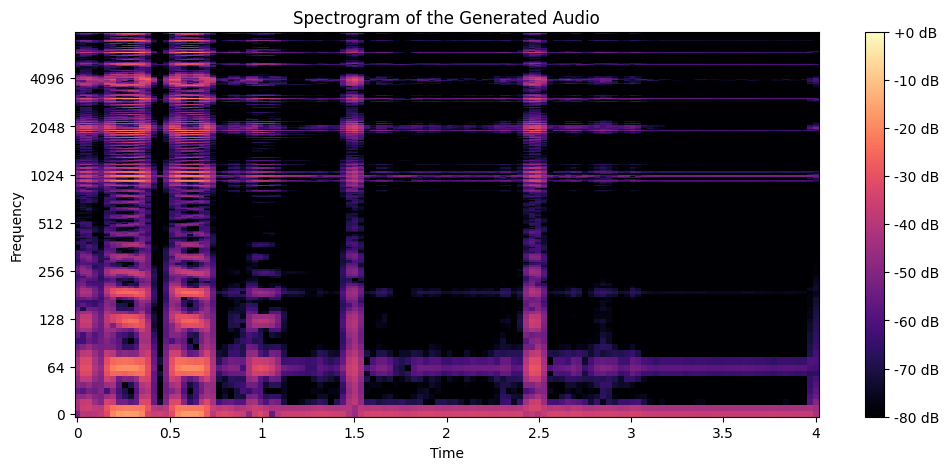

In [6]:
import librosa.display
import matplotlib.pyplot as plt

# Load the generated audio file
audio_path = 'generated_audio_guitar.wav'
audio_data, sample_rate = librosa.load(audio_path, sr=None)

# Plot the waveform
plt.figure(figsize=(12, 5))
plt.title("Waveform of the Generated Audio")
plt.plot(audio_data)
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

# Plot the spectrogram
plt.figure(figsize=(12, 5))
D = librosa.amplitude_to_db(np.abs(librosa.stft(audio_data)), ref=np.max)
librosa.display.specshow(D, sr=sample_rate, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram of the Generated Audio')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.show()

In [11]:
from scipy.stats import entropy

audio,sr = librosa.load("/Users/anandviswanath/Applied Ai/musicgen-watermelonsugar/generated_audio.wav", sr=16000)
pitches, magnitude = librosa.core.piptrack(y=audio,sr=16000)

# Extract non-zero pitches
pitches = pitches[pitches > 0]

# Count pitches, and probabilities
pitch_counts = np.bincount(pitches.astype(int))
pitch_probabilties = pitch_counts/ len(pitches)

# pitch entropy
pitch_entropy = entropy(pitch_probabilties)
print('Pitch Entropy =',pitch_entropy)

# pitch range
pitch_range = pitches.max() - pitches.min()
print('Pitch Range =',pitch_range)

unique_pitches = np.unique(pitches)
no_of_unique_pitches = len(unique_pitches)
print('No of pitches =',no_of_unique_pitches)

Pitch Entropy = 2.458483394375091
Pitch Range = 3026.1448
No of pitches = 86


## RESULTS
1. EPOCHS 50, 1000 audio files.
2. 100 audio files, 150 Epochs, 64 Batch Size
3. 10000 audio files​ 10 Epochs and 32 Batch size​

In [1]:
from keras.models import load_model
import numpy as np
import tensorflow as tf
import soundfile as sf
from IPython.display import Audio
import librosa

# Generating random tensorflow array for random noise.
noise = tf.random.normal([1, 100])
print(noise)

tf.Tensor(
[[-0.9913142   0.35325944 -0.5021495   1.2964926   0.08958957  0.21394761
   0.79118174  0.9431298   1.8201692   0.01470244  1.5651519   0.7855389
   0.85254896 -1.1798524   1.0734776  -0.29993495  0.88042367  0.14295992
   0.7767525   0.44241342  0.76421666 -0.62731147  0.46637118 -0.8727706
   0.21144882  1.6730456   0.39069813 -0.9362331   0.03516516  1.3163226
   1.6403929  -0.07680287  0.17614122  1.4547911  -0.85650754  1.377679
  -0.00525171 -0.28290758 -0.70400697  0.18722515 -0.4245803   0.47016147
   0.08951043  0.5645504  -0.8894888   0.15691783 -0.47309563 -0.6050864
  -0.559037    0.60246193 -0.16369404 -0.12819314 -2.1306748   0.5000646
  -0.2801686   0.62630033 -1.2347052   0.9580662  -1.159426    1.5158458
   0.7599213   2.7703583   1.401357    1.8213679  -0.05309102 -0.6180684
  -0.07349459 -1.7387173   0.48489958  1.1439282  -0.22682098 -0.3825214
  -0.7375609  -0.43046105 -1.8764621   1.247211   -0.6673977  -0.5556102
   0.73750085 -0.27544653 -0.410506   

In [44]:
import librosa
import numpy as np
from scipy.stats import gaussian_kde
from scipy.linalg import sqrtm
from scipy.special import kl_div

def extract_mfcc(file_path, n_mfcc=13):
    y, sr = librosa.load(file_path, sr=16000)  # Load audio file
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)  # Extract MFCCs
    return mfccs


def frechet_distance(mu1, sigma1, mu2, sigma2):
    """Compute the Frechet distance between two Gaussians."""
    diff = mu1 - mu2
    covmean = sqrtm(sigma1 @ sigma2)
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    return np.linalg.norm(diff) ** 2 + np.trace(sigma1 + sigma2 - 2 * covmean)

def compute_statistics(mfccs):
    """Compute the mean and covariance matrix of the MFCCs."""
    mean = np.mean(mfccs, axis=1)
    covariance = np.cov(mfccs)
    return mean, covariance

def compare_audio_files_fad(file1, file2):
    mfcc1 = extract_mfcc(file1)
    mfcc2 = extract_mfcc(file2)

    mu1, sigma1 = compute_statistics(mfcc1)
    mu2, sigma2 = compute_statistics(mfcc2)

    distance = frechet_distance(mu1, sigma1, mu2, sigma2)
    return distance

def compute_distribution(mfccs):
    # Flatten the MFCC matrix and normalize
    mfccs_flat = mfccs.flatten()
    # Estimate the density function using Gaussian KDE
    kde = gaussian_kde(mfccs_flat)
    return kde

def kl_divergence(p, q, x):
    #Calculate KL divergence D_KL(P || Q)
    p_x = p(x)
    q_x = q(x)
    return np.sum(kl_div(p_x, q_x))

def compare_audio_files(file1, file2):
    mfcc1 = extract_mfcc(file1)
    mfcc2 = extract_mfcc(file2)

    dist1 = compute_distribution(mfcc1)
    dist2 = compute_distribution(mfcc2)

    # Create a common grid of values to evaluate the distributions
    grid = np.linspace(min(mfcc1.flatten().min(), mfcc2.flatten().min()), 
                       max(mfcc1.flatten().max(), mfcc2.flatten().max()), 
                       num=1000)
    
    kl_div = kl_divergence(dist1, dist2, grid)
    return kl_div

# Original file
file1 = '/Users/anandviswanath/Applied Ai/nsynth-train/audio/guitar_electronic_035-062-127.wav'

1. EPOCHS 50, 1000 audio files.

In [25]:
# Load the generator model
generator = load_model('generator_model_guitar_50.keras')

# Load the discriminator model
discriminator = load_model('discriminator_model_guitar_50.keras')

# Function to generate and save a new audio sample
def generate_audio_sample(generator, noise_dim=100, sample_rate=16000, filename='1000_E_60.wav'):
    generated_audio = generator(noise, training=False)
    generated_audio = tf.reshape(generated_audio, [-1])
    generated_audio = generated_audio.numpy()
    generated_audio = (generated_audio - np.mean(generated_audio)) / np.std(generated_audio)
    generated_audio = generated_audio / np.max(np.abs(generated_audio))
    sf.write(filename, generated_audio, sample_rate)
    return Audio(data=generated_audio, rate=sample_rate)

audio_output = generate_audio_sample(generator)
audio_output

In [26]:
from scipy.stats import entropy

audio,sr = librosa.load("1000_E_60.wav", sr=16000)
pitches, magnitude = librosa.core.piptrack(y=audio,sr=16000)

# Extract non-zero pitches
pitches = pitches[pitches > 0]

# Count pitches, and probabilities
pitch_counts = np.bincount(pitches.astype(int))
pitch_probabilties = pitch_counts/ len(pitches)

# pitch entropy
pitch_entropy = entropy(pitch_probabilties)
print('Pitch Entropy =',pitch_entropy)

# pitch range
pitch_range = pitches.max() - pitches.min()
print('Pitch Range =',pitch_range)

unique_pitches = np.unique(pitches)
no_of_unique_pitches = len(unique_pitches)
print('No of pitches =',no_of_unique_pitches)

file2 = '1000_E_60.wav'

fad = compare_audio_files_fad(file1, file2)
kl_div = compare_audio_files(file1, file2)
print(f'KL Divergence between audio files: {kl_div}')
print(f'Frechet Distance between audio files: {fad}')

Pitch Entropy = 4.383303500017515
Pitch Range = 3809.2786
No of pitches = 1160
KL Divergence between audio files: 0.4550386877615762
Frechet Distance between audio files: 30216.458967963114


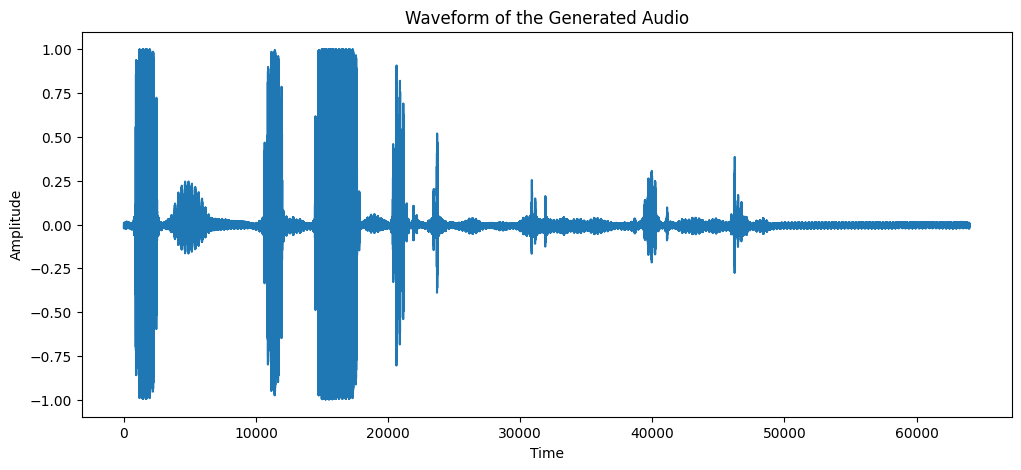

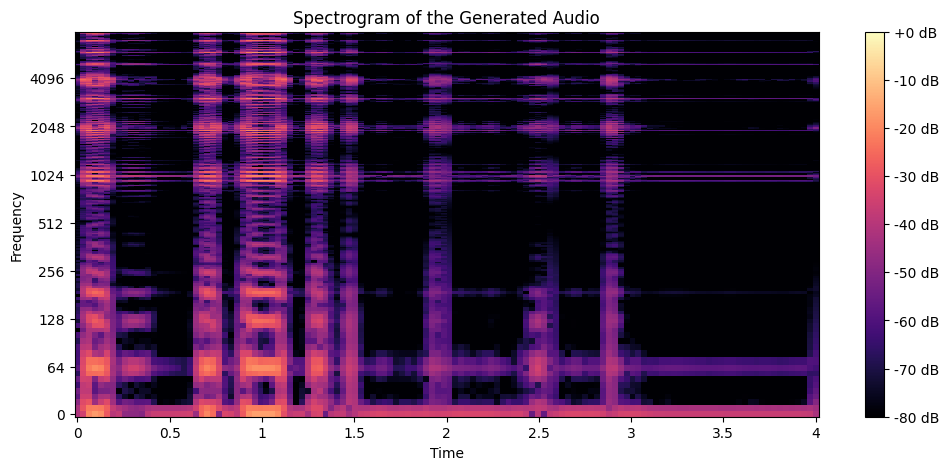

In [27]:
import librosa.display
import matplotlib.pyplot as plt

# Load the generated audio file
audio_path = '1000_E_60.wav'
audio_data, sample_rate = librosa.load(audio_path, sr=None)

# Plot the waveform
plt.figure(figsize=(12, 5))
plt.title("Waveform of the Generated Audio")
plt.plot(audio_data)
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

# Plot the spectrogram
plt.figure(figsize=(12, 5))
D = librosa.amplitude_to_db(np.abs(librosa.stft(audio_data)), ref=np.max)
librosa.display.specshow(D, sr=sample_rate, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram of the Generated Audio')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.show()

2. 100 audio files, 150 Epochs, 64 Batch Size

In [32]:
# 100 audio files, 150 Epochs, 64 Batch Size

# Load the generator model
generator = load_model('generator_model.h5')

# Load the discriminator model
discriminator = load_model('discriminator_model.h5')

# Function to generate and save a new audio sample
def generate_audio_sample(generator, noise_dim=100, sample_rate=16000, filename='a2.wav'):
    generated_audio = generator(noise, training=False)
    generated_audio = tf.reshape(generated_audio, [-1])
    generated_audio = generated_audio.numpy()
    generated_audio = (generated_audio - np.mean(generated_audio)) / np.std(generated_audio)
    generated_audio = generated_audio / np.max(np.abs(generated_audio))
    sf.write(filename, generated_audio, sample_rate)
    return Audio(data=generated_audio, rate=sample_rate)

audio_output = generate_audio_sample(generator)
audio_output


In [33]:
from scipy.stats import entropy

audio,sr = librosa.load("a1.wav", sr=16000)
pitches, magnitude = librosa.core.piptrack(y=audio,sr=16000)

# Extract non-zero pitches
pitches = pitches[pitches > 0]

# Count pitches, and probabilities
pitch_counts = np.bincount(pitches.astype(int))
pitch_probabilties = pitch_counts/ len(pitches)

# pitch entropy
pitch_entropy = entropy(pitch_probabilties)
print('Pitch Entropy =',pitch_entropy)

# pitch range
pitch_range = pitches.max() - pitches.min()
print('Pitch Range =',pitch_range)

unique_pitches = np.unique(pitches)
no_of_unique_pitches = len(unique_pitches)
print('No of pitches =',no_of_unique_pitches)

file2 = 'a1.wav'

fad = compare_audio_files_fad(file1, file2)
kl_div = compare_audio_files(file1, file2)
print(f'KL Divergence between audio files: {kl_div}')
print(f'Frechet Distance between audio files: {fad}')

Pitch Entropy = 2.939166362223697
Pitch Range = 3753.9744
No of pitches = 500
KL Divergence between audio files: 3.6030748032005917
Frechet Distance between audio files: 39065.768982611546


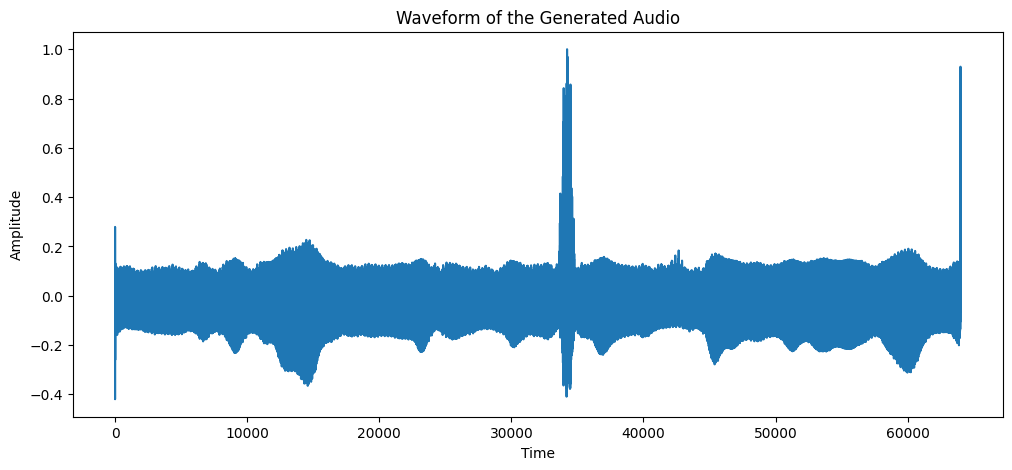

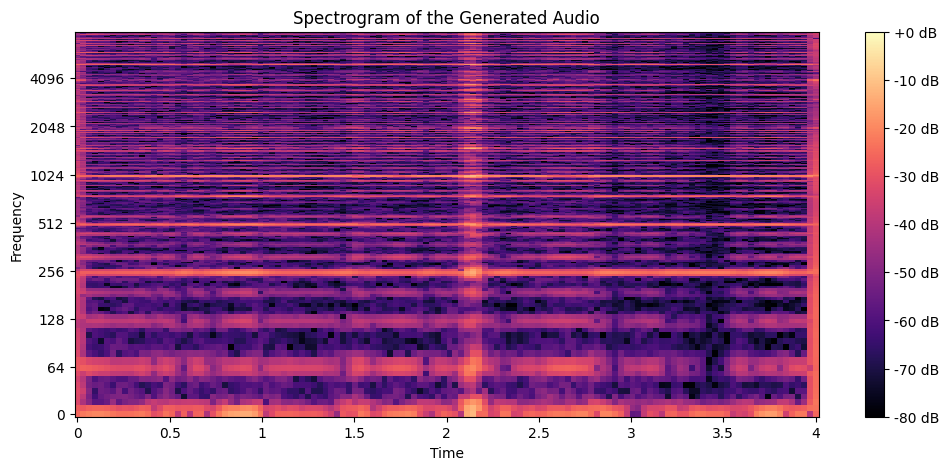

In [34]:
import librosa.display
import matplotlib.pyplot as plt

# Load the generated audio file
audio_path = 'a1.wav'
audio_data, sample_rate = librosa.load(audio_path, sr=None)

# Plot the waveform
plt.figure(figsize=(12, 5))
plt.title("Waveform of the Generated Audio")
plt.plot(audio_data)
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

# Plot the spectrogram
plt.figure(figsize=(12, 5))
D = librosa.amplitude_to_db(np.abs(librosa.stft(audio_data)), ref=np.max)
librosa.display.specshow(D, sr=sample_rate, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram of the Generated Audio')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.show()

3. 10000 audio files​ 10 Epochs and 32 Batch size​

In [37]:
# Load the generator model
generator = load_model('generator_model_guitar.h5')

# Load the discriminator model
discriminator = load_model('discriminator_model_guitar.h5')

# Function to generate and save a new audio sample
def generate_audio_sample(generator, noise_dim=100, sample_rate=16000, filename='a2.wav'):
    generated_audio = generator(noise, training=False)
    generated_audio = tf.reshape(generated_audio, [-1])
    generated_audio = generated_audio.numpy()
    generated_audio = (generated_audio - np.mean(generated_audio)) / np.std(generated_audio)
    generated_audio = generated_audio / np.max(np.abs(generated_audio))
    sf.write(filename, generated_audio, sample_rate)
    return Audio(data=generated_audio, rate=sample_rate)

audio_output = generate_audio_sample(generator)
audio_output


In [45]:
from scipy.stats import entropy

audio,sr = librosa.load("a2.wav", sr=16000)
pitches, magnitude = librosa.core.piptrack(y=audio,sr=16000)

# Extract non-zero pitches
pitches = pitches[pitches > 0]

# Count pitches, and probabilities
pitch_counts = np.bincount(pitches.astype(int))
pitch_probabilties = pitch_counts/ len(pitches)

# pitch entropy
pitch_entropy = entropy(pitch_probabilties)
print('Pitch Entropy =',pitch_entropy)

# pitch range
pitch_range = pitches.max() - pitches.min()
print('Pitch Range =',pitch_range)

unique_pitches = np.unique(pitches)
no_of_unique_pitches = len(unique_pitches)
print('No of pitches =',no_of_unique_pitches)

file2 = 'a2.wav'

fad = compare_audio_files_fad(file1, file2)
kl_div = compare_audio_files(file1, file2)
print(f'KL Divergence between audio files: {kl_div}')
print(f'Frechet Distance between audio files: {fad}')

Pitch Entropy = 3.255078681464667
Pitch Range = 3746.9033
No of pitches = 540
KL Divergence between audio files: 4.874558921257769
Frechet Distance between audio files: 41400.217251980335


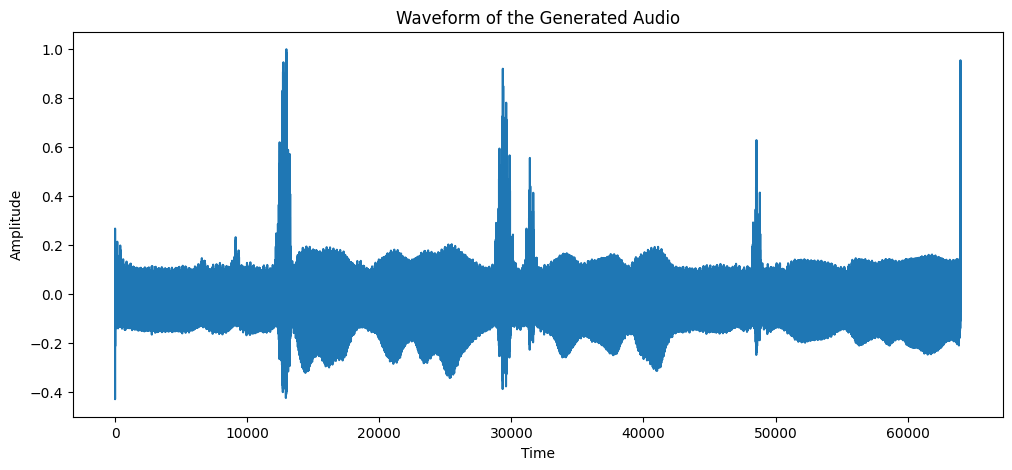

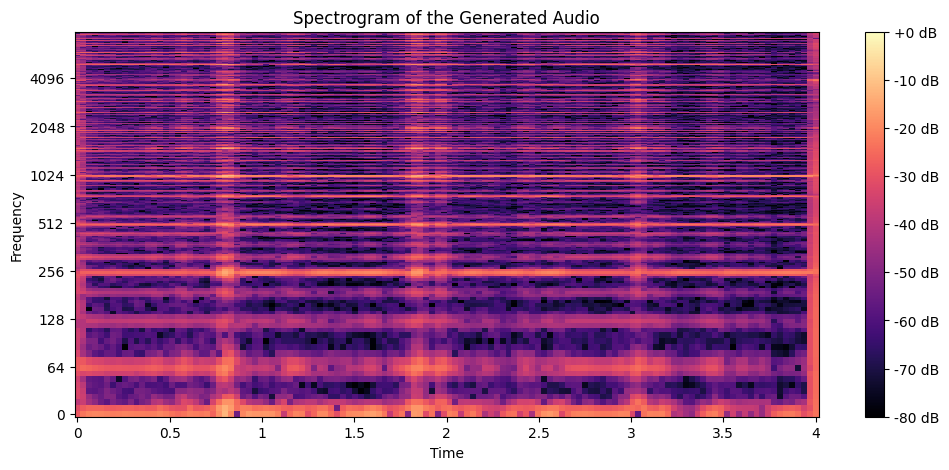

In [46]:
import librosa.display
import matplotlib.pyplot as plt

# Load the generated audio file
audio_path = 'a2.wav'
audio_data, sample_rate = librosa.load(audio_path, sr=None)

# Plot the waveform
plt.figure(figsize=(12, 5))
plt.title("Waveform of the Generated Audio")
plt.plot(audio_data)
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

# Plot the spectrogram
plt.figure(figsize=(12, 5))
D = librosa.amplitude_to_db(np.abs(librosa.stft(audio_data)), ref=np.max)
librosa.display.specshow(D, sr=sample_rate, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram of the Generated Audio')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.show()